{'pageTitle': 'SHEIN SXY Solid Zipper Front Ribbed Knit Cami Top | SHEIN USA', 'pageKeywords': '', 'pageDescription': 'Free Returns ✓ Free Shipping✓. SHEIN SXY Solid Zipper Front Ribbed Knit Cami Top- Women Tank Tops & Camis at SHEIN.', 'rs': {'detail': {'goods_id': '25161573', 'goods_sn': 'sz2309190773447086'}}, 'templateType': 'goods_detail', 'nlkt': 0, 'ssrAbtKey': 'hidefreeshippingtype=sellingpointtype=Aexposure_prime_priceXDetailShowQuickis_pde=3&rule_id_120=rec_ver:S120V3.0&rule_id_121=rec_ver:S121M2.4test_rec_ver_s120tj_rec_ver_120scc_rulev6229tj_rec_ver_121scc_rulev6231recSwitch50|52|53|93|160|141|139|167|156|157|158|166|168|103FlashZoneFlashNewcomerAndSpecialVideotestimageareanonefreestylestripitemfreeshippingfreeremindfrequentlycontentnotshowgtlshowshowoutfitshownotshowgtllocationalonemanyrecommendoldnonesimilarrowsnotshowfrequentlylocationunderfrequentlydefaultsimilarlocationtoponlyxlefttenpcstoreopencloserangedetailtypelALogisticsTimeBSizeTipsBUnderPriceShowAUnderPriceFeeds
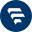
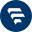

In [8]:
'''
0. Define amount of links per scraping batch
   - Assign limit = 3

1. Get most recent list of links
   - Find all .csv files in links/
   - Order them alphabetically (Z->A)
   - Assign first one to `links` variable
   
2. Shuffle links order 
   - Randomize order
   - Assign to "randomized_links" variable

3. Prioritize links order 
   - Create empty list `existing_links`
   - Create empty list `new_links`
   - For each item in randomized_links
     - If it exists in my `items/` folder as {item.id}.csv 
       - Append it to `existing_links`
     - Otherwise
       - Append it to `new_links`
   - Create `prioritized_list`, concatenating `new_links` and `existing_links`

4. Define get_item_details(link, id) function
   - Simulate a browser access with Selenium
   - Get item details:
     - Title
     - Type
     - Image
     - Price
     - SKU
     - Composition
   - Save it in `items/` folder as {id}.csv 

5. Get all items details
   - Keep only the first `limit` elements in prioritized_list
   - For each link in prioritized_list
     - Call `get_item_details(link, id)` function
'''

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import datetime
import random
import re
import os
import time
import json

# Define directory for saving item details CSVs
output_folder = 'items/'
links_folder = 'links/'

# Define the amount of links per scraping batch
limit = 1

# Get the most recent list of links
def get_most_recent_csv(directory):
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    csv_files.sort(reverse=True)
    return os.path.join(directory, csv_files[0]) if csv_files else None

links_file = get_most_recent_csv(links_folder)
links = pd.read_csv(links_file) if links_file else []

# Shuffle links order
randomized_links = links.sample(frac=1).reset_index(drop=True)

# Prioritize links order
existing_links = []
new_links = []

for _, row in randomized_links.iterrows():
    item_id = row['Item ID']
    link = row['Link']
    file_path = f'{output_folder}{item_id}.csv'
    if os.path.exists(file_path):
        existing_links.append((item_id, link))
    else:
        new_links.append((item_id, link))

prioritized_list = new_links + existing_links

# Warm the engines for scraping

# Setting a realistic user agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36"

# Configure Chrome Options for Headless Mode
options = Options()
options.add_argument(f'user-agent={user_agent}')
options.add_argument("--no-sandbox")  # Bypass OS security model, necessary for Docker and certain CI environments
options.add_argument("--disable-dev-shm-usage")  # Overcome limited resource problems
options.add_argument("--disable-gpu")  # Applicable to windows os only
options.add_argument("--disable-setuid-sandbox")

# Initialize Selenium WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Define get_item_details function
def get_item_details(link, item_id):
    driver.get(link)
    time.sleep(random.uniform(5, 10))
    
    # Get hardcoded JSON
    def extract_json():
        # Find the script tag containing the specific text
        target_text = "window.goodsDetailV3SsrData"
        script_tags = driver.find_elements(By.TAG_NAME, "script")
        for script_tag in script_tags:
            script_content = script_tag.get_attribute('innerHTML')
            if target_text in script_content:
                match = re.search(r'{.*}', script_content)
                if match:
                    return json.loads(match.group(0))
        return {}

    # Get JSON from script tag
    parsed_json = extract_json()
    
    # Get Title
    try:
        title = driver.find_element(By.TAG_NAME, 'h1').text
    except Exception:
        title = "" 
    
    # Get Image
    try:
        img_tag = driver.find_element(By.CSS_SELECTOR, "img[data-src]")
        image = img_tag.get_attribute('data-src')
        if image.startswith('//'):
            image = 'https:' + image
    except Exception:
        image = ""
    
    # Get Price
    try:
        price_element = driver.find_element(By.CSS_SELECTOR, ".product-intro__head-mainprice [aria-label]")
        price_text = price_element.text
        # Remove currency symbols and convert to float
        price = float(re.sub(r'[^\d.]+', '', price_text))
    except Exception:
        price = ""

    
    # Get SKU
    
    # Get Composition
    
    # Get Timestamp
    timestamp = datetime.datetime.now()
    
    # Include the item name in the details
    item_details = [[title, price, image, timestamp, link]]
        
    # Creating DataFrame
    df = pd.DataFrame(item_details, columns=['Title', 'Price', 'Image', 'Timestamp', 'Link'])
    
    # Save to CSV
    df.to_csv(f"{output_folder}{item_id}.csv", index=False)


# Create a new directory 'items' if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get all items details
for item_id, link in prioritized_list[:limit]:
    get_item_details(link, item_id)

driver.quit() # Close the browser